In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
#from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from functions import *

## Read

1. Агрегировать данные по часу
2. Создать train/test метка времени + 1/0

In [2]:
# injuries = pd.read_csv('data/SANRAL_v2/Injuries2016_2019.csv')
# vehicles = pd.read_csv('data/SANRAL_v2/Vehicles2016_2019.csv')

In [3]:
train = pd.read_csv('data/train.csv')

In [4]:
# drop lines with bad road_segment_id
train['rs_len'] = train['road_segment_id'].apply(lambda x: len(x))
train = train[train['rs_len'] == 7]

In [5]:
# create train sample

road_segment_id = train['road_segment_id'].unique()
agg_train = pd.DataFrame([])
agg_train['ts'] = pd.date_range(start='2016-01-01', end='2018-12-31', freq='h')
rs = [road_segment_id]*agg_train.shape[0]
agg_train['rs_list'] = rs

data = []
for i in agg_train.itertuples():
    lst = i[2]
    for col2 in lst:
        data.append([i[1], col2])

df_output = pd.DataFrame(data=data, columns=agg_train.columns) 

In [6]:
dt = [datetime.strptime(x, "%d/%m/%y %H:%M") for x in train['Occurrence Local Date Time'].values]
train['dt'] = dt
train['hour_dt'] = train['dt'].dt.round('60min')

In [7]:
# Aggregating train

base_df = df_output.merge(train[['hour_dt', 'road_segment_id', 'EventId']], 
                          left_on=['ts', 'rs_list'], 
                          right_on=['hour_dt', 'road_segment_id'],
                          how='left')\
                   .drop(['hour_dt', 'road_segment_id'], axis=1)

In [8]:
base_df['target'] = base_df['EventId'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [9]:
base_df['target'].value_counts()

0    14245462
1       53738
Name: target, dtype: int64

In [10]:
t1 = base_df[base_df['ts']>='2018-10-01']

In [11]:
t1.shape

(1189050, 4)

In [12]:
t2 = base_df[(base_df['target']==1)&(base_df['ts']<'2018-10-01')]

In [13]:
t2.shape

(45524, 4)

In [14]:
t3 = base_df[(base_df['target']==0)&(base_df['ts']<'2018-10-01')].sample(n=100000)

In [17]:
train = pd.concat((pd.concat((t1, t2)), t3)).reset_index(drop=True)

In [18]:
train.shape

(1334574, 4)

In [19]:
train['target'].value_counts()

0    1280836
1      53738
Name: target, dtype: int64

In [20]:
del base_df, df_output, data

In [21]:
del agg_train

## Weather

In [22]:
weather = pd.read_csv('data/weather_train.csv', sep=';')
weather = weather.drop(['Unnamed: 13', 'Unnamed: 14', "W'W'", 'ff10'], axis=1)

weather_cols = ['local_time', 'temperature', 'p0', 'p', 'humidity', 'mean_wind_direction', 
                'mean_wind_speed', 'special_weather_phenomena', 'clouds', 'horizontal_visibility', 'Td']

weather.columns = weather_cols
weather_2 = weather_prep(weather.copy())

In [23]:
weather_2.shape

(25920, 46)

## Geo

In [28]:
#tz_2018_1 = pd.read_csv('data/cape_town-travel_zones-2018-1-All-HourlyAggregate.csv')

In [35]:
# seg = gpd.read_file('data/road_segments/road_segments.geojson')

# seg['CLASS_PRIMARY'] = seg['CLASS'].apply(lambda x: 1 if x=='Primary' else 0)
# seg['PAVETYPE_FLEX'] = seg['PAVETYPE'].apply(lambda x: 1 if x=='FLEX' else 0)
# seg['SURFTYPE_PAVED'] = seg['SURFTYPE'].apply(lambda x: 1 if x=='Paved' else 0)
# seg['CONDITION_VG'] = seg['CONDITION'].apply(lambda x: 1 if x=='Very Good' else 0)
# seg['CONDITION_G']  = seg['CONDITION'].apply(lambda x: 1 if x=='Good' else 0)
# seg['CONDITION_F']  = seg['CONDITION'].apply(lambda x: 1 if x=='Fair' else 0)
# seg['ROADNO_N1'] = seg['ROADNO'].apply(lambda x: 1 if x=='N1' else 0)
# seg['ROADNO_N2'] = seg['ROADNO'].apply(lambda x: 1 if x=='N2' else 0)
# seg['ROADNO_N7'] = seg['ROADNO'].apply(lambda x: 1 if x=='N7' else 0)
# seg['ROADNO_R300'] = seg['ROADNO'].apply(lambda x: 1 if x=='R300' else 0)
# seg['ROADNO_M3'] = seg['ROADNO'].apply(lambda x: 1 if x=='M3' else 0)
# seg['ROADNO_M4'] = seg['ROADNO'].apply(lambda x: 1 if x=='M4' else 0)
# seg['ROADNO_M5'] = seg['ROADNO'].apply(lambda x: 1 if x=='M5' else 0)
# seg['ROADNO_M17'] = seg['ROADNO'].apply(lambda x: 1 if x=='M17' else 0)
# seg.drop(['CONDITION', 'CLASS', 'PAVETYPE','SURFTYPE', 'ROADNO', 'REGION','geometry'] , axis=1, inplace=True)

In [24]:
seg = pd.read_pickle('data/seg.pickle')

In [25]:
seg.drop(['REGION'], axis=1, inplace=True)
seg.head()

,WIDTH,LANES,length_1,segment_id,CLASS_PRIMARY,PAVETYPE_FLEX,SURFTYPE_PAVED,CONDITION_VG,CONDITION_G,CONDITION_F,ROADNO_N1,ROADNO_N2,ROADNO_N7,ROADNO_R300,ROADNO_M3,ROADNO_M4,ROADNO_M5,ROADNO_M17
0,20.2,2,471.207,D1U6OOF,1,1,1,0,1,0,0,0,0,1,0,0,0,0
1,20.2,2,471.207,NG4X2MD,1,1,1,0,1,0,0,0,0,1,0,0,0,0
2,20.2,2,471.207,792705Z,1,1,1,0,1,0,0,0,0,1,0,0,0,0
3,20.2,2,471.207,IK67XHB,1,1,1,0,1,0,0,0,0,1,0,0,0,0
4,20.2,2,471.207,OWCF2MH,1,1,1,0,1,0,0,0,0,1,0,0,0,0


## Uber data

In [13]:
# q1_2018 = pd.read_csv('data/cape_town-travel_zones-2018-1-All-HourlyAggregate.csv')

# q2_2018 = pd.read_csv('data/cape_town-travel_zones-2018-2-All-HourlyAggregate.csv')

# q3_2018 = pd.read_csv('data/cape_town-travel_zones-2018-3-All-HourlyAggregate.csv')

# q4_2018 = pd.read_csv('data/cape_town-travel_zones-2018-4-All-HourlyAggregate.csv')

## Feats join

In [39]:
# pol = gpd.read_file('data/cape_town_travel_zones.json')
# pd.merge(base_df, gpd.sjoin(seg, pol[['fake_gavno', 'geometry']])[['segment_id', 'fake_gavno']], on='segment_id')

In [26]:
train = train.rename(columns={'rs_list':'segment_id'})#.head(2)

In [27]:
train_2 = train.merge(seg, on='segment_id', how='left')\
                 .merge(weather_2, left_on='ts', right_on='hour_dt', how='left')\
                 .drop('hour_dt', axis=1)

In [28]:
# del base_df, seg, weather_2

In [55]:
# train_2.to_pickle('data/train_2.pickle')

# Train

In [21]:
# %%time
# train_2 = pd.read_pickle('data/train_2.pickle')

In [29]:
train_2 = train_2.fillna(-1)

In [30]:
test = train_2[train_2['ts'] >= '2018-10-01']
train = train_2[train_2['ts'] < '2018-10-01']

In [31]:
train['target'].value_counts()

0    100000
1     45524
Name: target, dtype: int64

In [32]:
test['target'].value_counts()

0    1180836
1       8214
Name: target, dtype: int64

## Feature selection

In [36]:
X = train.drop(['ts', 'segment_id', 'EventId', 'target'], axis=1)
y = train['target'].values

In [35]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [42]:
rf = RandomForestClassifier()

In [49]:
# Задаем схему кросс-валидации
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
rf_random = RandomizedSearchCV(estimator=rf, 
                               param_distributions=random_grid, 
                               n_iter=5, 
                               cv=cv, 
                               scoring='roc_auc',
                               verbose=3, 
                               random_state=1, 
                               n_jobs=2)

rf_random.fit(X, y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed: 21.2min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_...
                   param_distributions={'bootstrap': [True, False],
      

In [50]:
rf_random.best_score_

0.8271106880805453

In [52]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=40, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [53]:
pred = rf_random.predict_proba(test.drop(['ts', 'segment_id', 'EventId', 'target'], axis=1))

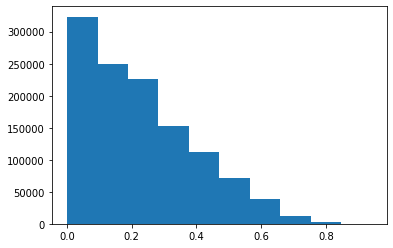

In [54]:
plt.hist(pred[:,1]);

In [55]:
roc_auc_score(test['target'], pred[:, 1])

0.7550230491867387

In [56]:
from sklearn.metrics import classification_report, f1_score

In [57]:
res = []
for prc in range(1, 100, 1):
    thr = np.percentile(pred[:,1], prc)
    pred_ll = [1 if x >= thr else 0 for x in pred[:, 1]]
    res.append([thr, f1_score(test['target'], pred_ll)])

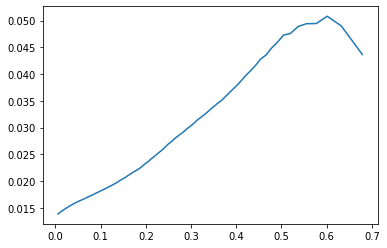

In [58]:
plt.plot([x[0] for x in sorted(res, key=lambda x: x[0], reverse=True)], [x[1] for x in sorted(res, key=lambda x: x[0], reverse=True)])

In [59]:
best_thr = sorted(res, key=lambda x: x[1], reverse=True)[0][0]
best_thr

0.6012600192098999

In [60]:
best_f1 = sorted(res, key=lambda x: x[1], reverse=True)[0][1]
best_f1

0.05081231344133797

## Check threshold

In [61]:
# кастомные метрики

def m_roc(y_true, y_pred, percent):   
    mask = y_pred[:,1] >= np.percentile(y_pred[:,1], percent)
    return roc_auc_score(y_true=y_true[mask], y_score=y_pred[mask,1])

 
def m_presicion(y_true, y_pred, percent):
    mask = y_pred[:,1] >= np.percentile(y_pred[:,1], percent)
    return y_true[mask].sum()/y_true[mask].shape[0], y_true[mask].shape[0]

def m_recall(y_true, y_pred, percent):
    mask = y_pred[:,1] >= np.percentile(y_pred[:,1], percent)
    return y_true[mask].sum()/y_true.sum()

def m_presicion_in_percent(y_true, y_pred, percent, step):
    height_percent = percent + step if percent + step <= 100 else 100
    mask = (np.percentile(y_pred[:,1], percent) <= y_pred[:,1]) & (np.percentile(y_pred[:,1], height_percent) >  y_pred[:,1])
    return y_true[mask].sum()/y_true[mask].shape[0]

In [62]:
def prc_graphs(y_test, predict_test):
    y_true = y_test
    y_pred = predict_test
    coef = sum(y_true) / len(y_true)
    test_df = pd.DataFrame()
    # Метрики по перцентилям
    percent_set = set(range(100))
    for j in percent_set:
        roc = m_roc(y_true, y_pred, percent=j)
        prs, cnt_user = m_presicion(y_true, y_pred, percent=j)
        prc_in_percentile = m_presicion_in_percent(y_true, y_pred, percent=j, step=j)
        rec = m_recall(y_true, y_pred, percent=j)
        f1 =(2*prs*rec)/(prs + rec)
        lift = np.round(prs / coef, 2)
        threshold = np.percentile(y_pred[:,1], j)
        test_df = test_df.append([[j, threshold, cnt_user, roc, prs, rec, prc_in_percentile, f1, lift]])
    test_df.columns =  ['percent', 'threshold', 'cnt_user', 'roc', 'prc', 'rec', 'prc_in_percentile', 'f1', 'lift']  
    return test_df

 

def draw_prc_rc_f1(test_df):
    f, ax = plt.subplots(figsize=(20, 20))
    plt.subplot(211)
    plt.plot(test_df.percent, test_df.prc, 'o-',label='TEST: presicion');
    plt.plot(test_df.percent, test_df.rec, 'o-',label='TEST: recall');
    plt.plot(test_df.percent, test_df.f1, 'o-',label='TEST: f1');
    plt.grid();
    plt.title('presicion & recall')
    plt.xlabel('percent');
    plt.legend();

/home/jupyter/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


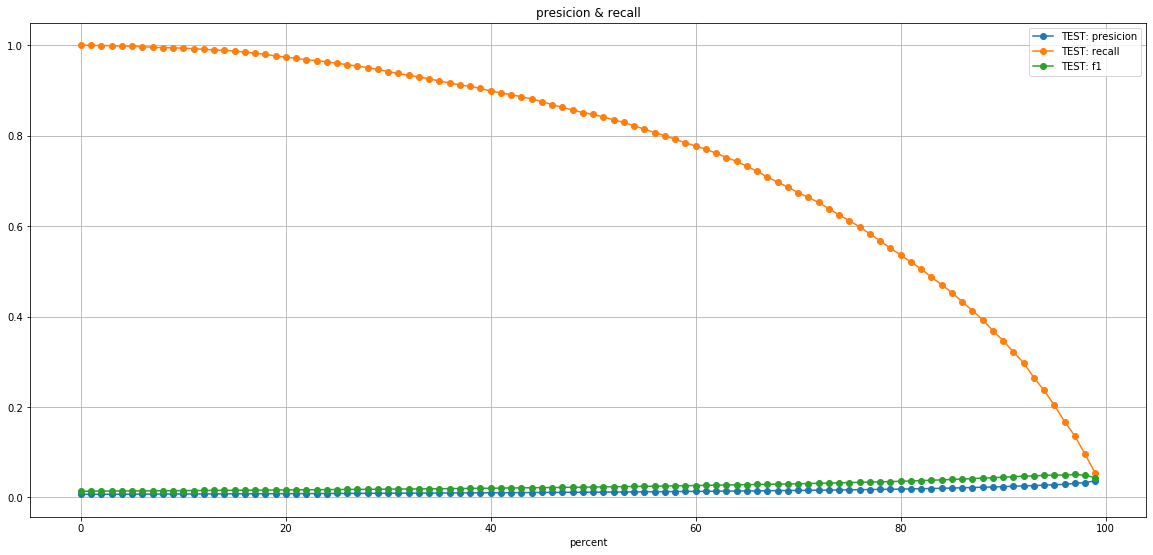

In [63]:
test_graph = prc_graphs(test['target'], pred) 
draw_prc_rc_f1(test_graph)

## CV

In [4]:
!pip install --user xgboost 

  Using cached https://files.pythonhosted.org/packages/c1/24/5fe7237b2eca13ee0cfb100bec8c23f4e69ce9df852a64b0493d49dae4e0/xgboost-0.90-py2.py3-none-manylinux1_x86_64.whl


In [5]:
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
xgb = XGBClassifier()

param_grid = {
          'n_estimators':  range(150, 400, 50),
          'learning_rate': [.1],
          'max_depth': range(3, 8, 2),
          'subsample': [ .5, .6, .95, 1],
          'gamma': [0, .05, .1, .2, .25, 0.01, 0.02],
          'colsample_bytree': [1, .8, .50],
          'reg_alpha': [0, 0.1, 0.3, 0.5, 0.7, 1],
          'reg_lambda': [0, 0.01, 0.1, 0.2, 0.5, 1, 5, 10],
          'scale_pos_weight': [1, 10, 25, 50]
}

In [ ]:
# Задаем схему кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Запускаем поиск гиперпараметров
hyper_search = RandomizedSearchCV(pipe, param_grid, n_iter=30, scoring='roc_auc', cv=cv,
                                  n_jobs=-1, refit=True, random_state=42, verbose=2)

hyper_search.fit(matr_train, y_train)

## Test prediction

In [64]:
ss = pd.read_csv('data/SampleSubmission.csv')

In [65]:
ss.head()

,datetime x segment_id,prediction
0,2019-01-01 01:00:00 x S0B3CGQ,NaN
1,2019-01-01 01:00:00 x RYJYAPI,NaN
2,2019-01-01 01:00:00 x U3KP57C,NaN
3,2019-01-01 01:00:00 x RY0TRQ8,NaN
4,2019-01-01 01:00:00 x 8LOVJZ3,NaN


In [67]:
ss_2 = ss['datetime x segment_id'].str.split(pat=' x ', expand=True).rename(columns={0:'dt', 1:'segment_id'})#.apply(pd.Series)

In [68]:
dt = [datetime.strptime(x[2:], "%y-%m-%d %H:%M:%S") for x in ss_2['dt'].values]
ss_2['dt'] = dt
ss_2['hour_dt'] = ss_2['dt'].dt.round('60min')

In [69]:
ss_2.drop(['dt'], axis=1, inplace=True)

In [70]:
ss_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174496 entries, 0 to 1174495
Data columns (total 2 columns):
segment_id    1174496 non-null object
hour_dt       1174496 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 17.9+ MB


### Weather

In [71]:
weather_test = pd.read_csv('data/weather_test.csv', sep=';')

weather_test = weather_test.drop(["W'W'", 'ff10'], axis=1)

weather_cols = ['local_time', 'temperature', 'p0', 'p', 'humidity', 'mean_wind_direction', 
                'mean_wind_speed', 'special_weather_phenomena', 'clouds', 'horizontal_visibility', 'Td']

weather_test.columns = weather_cols
weather_test_2 = weather_prep(weather_test.copy())

### Join

In [72]:
ss_2.head()

,segment_id,hour_dt
0,S0B3CGQ,2019-01-01 01:00:00
1,RYJYAPI,2019-01-01 01:00:00
2,U3KP57C,2019-01-01 01:00:00
3,RY0TRQ8,2019-01-01 01:00:00
4,8LOVJZ3,2019-01-01 01:00:00


In [73]:
test_1 = ss_2.merge(seg, on='segment_id', how='left')

In [74]:
test_2 = test_1.merge(weather_test_2, left_on='hour_dt', right_on='hour_dt', how='left').drop('hour_dt', axis=1)

In [75]:
test_2 = test_2.fillna(-1)

In [76]:
pred_test = rf_random.predict_proba(test_2.drop(['segment_id'], axis=1))

In [77]:
pred_test_l = [1 if x >= best_thr else 0 for x in pred_test[:, 1]]
best_thr

0.6012600192098999

In [78]:
ss['prediction'] = pred_test_l

In [79]:
ss.shape, len(pred_test)

((1174496, 2), 1174496)

In [80]:
sum(pred_test_l)

58258

In [81]:
ss.to_csv('data/submission_2.csv', index=False)